In [1]:
import os

%load_ext autoreload
%autoreload 2

""""
To make final (MS) figures (pretty) for shape category neural psycho.
This links to script: /home/lucas/code/neuralmonkey/neuralmonkey/scripts/analy_decode_moment_psychometric.py
Older notebook more fleshed out, where devoed the code in that scrpt: /home/lucas/code/neuralmonkey/neuralmonkey/notebooks_tutorials/240617_momentbymoment_decode_psychoprim.ipynb

Focus here is on SWITCHING morph expts.
"""

'"\nTo make final (MS) figures (pretty) for shape category neural psycho.\nThis links to script: /home/lucas/code/neuralmonkey/neuralmonkey/scripts/analy_decode_moment_psychometric.py\nOlder notebook more fleshed out, where devoed the code in that scrpt: /home/lucas/code/neuralmonkey/neuralmonkey/notebooks_tutorials/240617_momentbymoment_decode_psychoprim.ipynb\n\nFocus here is on SWITCHING morph expts.\n'

# Load a dataset

In [2]:
from neuralmonkey.scripts.analy_dfallpa_extract import extract_dfallpa_helper
from neuralmonkey.classes.population_mult import load_handsaved_wrapper, dfpa_match_chans_across_pa_each_bregion
from neuralmonkey.classes.population_mult import extract_single_pa
from neuralmonkey.metadat.analy.anova_params import params_getter_euclidian_vars
from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_clean_bad_channels, dfpa_concatbregion_preprocess_wrapper
from pythonlib.tools.pandastools import append_col_with_grp_index
import seaborn as sns
from pythonlib.tools.plottools import savefig
import os
from neuralmonkey.classes.population_mult import extract_single_pa
from neuralmonkey.analyses.state_space_good import euclidian_distance_compute_trajectories_single, euclidian_distance_compute_trajectories


In [ ]:
# animal = "Diego"
# date = 240517

animal = "Pancho"
date = 240524
SAVEDIR_ALL = f"/tmp/PSYCHO_SP/{animal}-{date}"
os.makedirs(SAVEDIR_ALL, exist_ok=True)


In [ ]:
from neuralmonkey.scripts.analy_dfallpa_extract import extract_dfallpa_helper

question = "SP_psycho_trial"
which_level = "trial"
fr_normalization_method = "across_time_bins" # Slightly better
LIST_BREGION_IGNORE = ["FP", "FP_p", "FP_a"]
COMBINE_AREAS = True

#####################################
# Method 2 - Combine two dfallpa
DFallpa = load_handsaved_wrapper(animal=animal, date=date, version="trial", combine_areas=COMBINE_AREAS, question=question)

#################### PREPROCESSING
from neuralmonkey.classes.population_mult import dfpa_concatbregion_preprocess_clean_bad_channels, dfpa_concatbregion_preprocess_wrapper
dfpa_concatbregion_preprocess_wrapper(DFallpa, animal, date, fr_mean_subtract_method=fr_normalization_method)

from neuralmonkey.scripts.analy_pig_decode_moment_syntaxTI import dfallpa_preprocess_condition
shape_var_suff = "shape"
loc_var_suff = "loc"
dfallpa_preprocess_condition(DFallpa, shape_var_suff, loc_var_suff)

from neuralmonkey.analyses.decode_moment import analy_psychoprim_prepare_beh_dataset
savedir = f"{SAVEDIR_ALL}/morphsets_drawings"
os.makedirs(savedir, exist_ok=True)
DSmorphsets, map_tc_to_morph_info, map_morphset_to_basemorphinfo, map_tcmorphset_to_idxmorph, map_tcmorphset_to_info, \
    map_morphsetidx_to_assignedbase_or_ambig, map_tc_to_morph_status = analy_psychoprim_prepare_beh_dataset(animal, date, savedir)

# Hacky, remove trialcodes that are by eye messy
from pythonlib.dataset.dataset_analy.psychometric_singleprims import params_good_morphsets_switching_ignore_trialcodes
trialcodes_ignore = params_good_morphsets_switching_ignore_trialcodes(animal, date)

# Prune neural data to keep only good triacldoes.
list_trialcode = DSmorphsets.Dat["trialcode"].unique().tolist() # trialcodes that are in DSmorphsets
list_trialcode = [tc for tc in list_trialcode if tc not in trialcodes_ignore]

# Do prune
DFallpa["pa"] = [pa.slice_by_labels("trials", "trialcode", list_trialcode) for pa in DFallpa["pa"].values]


# All analyses

### Devo

##### Preprocess

In [ ]:
from neuralmonkey.analyses.state_space_good import trajgood_plot_colorby_splotby_WRAPPER, trajgood_plot_colorby_splotby_scalar_WRAPPER
from neuralmonkey.scripts.analy_decode_moment_psychometric import analy_switching_GOOD_state_space, analy_extract_PA_conditioned, analy_switching_statespace_euclidian_good, analy_switching_statespace_euclidian_traj, _analy_switching_statespace_euclidian_traj_condition, _analy_switching_statespace_euclidian_traj_plots, _analy_extract_PA_dim_reduction

In [ ]:
TWIND_ANALY = (-0.6, 1.0) # This is just for windowing final data, not for fitting pca.
morphset = 8
SAVEDIR = f"{SAVEDIR_ALL}/morphset={morphset}"


In [ ]:
savedir = f"{SAVEDIR}/preprocess"
os.makedirs(savedir, exist_ok=True)

In [ ]:
raw_subtract_mean_each_timepoint = False
NPCS_KEEP = 8
scalar_or_traj = "traj"
# Then can take longer time window
tbin_dur = 0.2
tbin_slide = 0.01

bregion = "PMv"

fit_twind = (0.05, 0.9)

dim_red_method = "dpca"
EVENT = "03_samp"

final_twind = TWIND_ANALY

_, PAredu = analy_extract_PA_conditioned(DFallpa, bregion, morphset, map_tcmorphset_to_idxmorph, map_tcmorphset_to_info,
                                            scalar_or_traj, EVENT, raw_subtract_mean_each_timepoint, 
                    dim_red_method, final_twind, tbin_dur, tbin_slide, NPCS_KEEP, 
                    savedir, restricted_twind_for_dpca=fit_twind, exclude_flankers=True)


##### State space (trajectories)

In [ ]:
savedir = f"{SAVEDIR}/state_space"
os.makedirs(savedir, exist_ok=True)

In [ ]:
analy_switching_statespace_euclidian_good(PAredu, savedir) 

##### Analysis -- distance scores (convert to distance index)


In [ ]:
savedir = f"{SAVEDIR}/dist_index"
os.makedirs(savedir, exist_ok=True)

In [ ]:
### Analysus -- single trials, adn timecourses
analy_switching_statespace_euclidian_traj(PAredu, savedir)


### FINAL GOOD PLOTS

In [ ]:
from pythonlib.tools.statstools import stratified_kfold_single_test


In [ ]:
    X = np.random.rand(10, 5)  # 10 samples, 5 features
    y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4])  # Some classes have < n_splits samples

    n_splits = 3
    shuffle = True
    random_state = None

    folds = stratified_kfold_single_test(X, y, n_splits, shuffle, random_state)
    for i, (train_idx, test_idx) in enumerate(folds):
        print(f"Fold {i+1}:")
        print(f"  Train indices: {train_idx}")
        print(f"  Test indices: {test_idx}")


In [ ]:
y

In [ ]:
import numpy as np
from pythonlib.tools.statstools import stratified_kfold_single_test

# Example usage
X = np.random.rand(10, 5)  # 10 samples, 5 features
y = np.array([0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4])  # Some classes have < n_splits samples

n_splits = 3
shuffle = True
random_state = None

folds = stratified_kfold_single_test(X, y, n_splits, shuffle, random_state, PRINT=True)
# for i, (train_idx, test_idx) in enumerate(folds):
#     print(f"Fold {i+1}:")
#     print(f"  Train indices: {train_idx}")
#     print(f"  Test indices: {test_idx}")

# train_inds = []
# test_inds = []
# for f in folds:
#     train_inds.extend(f[0])
#     test_inds.extend(f[1])
# print(sorted(train_inds))
# print(sorted(test_inds))

In [ ]:

list_morphset = [1,8]
analy_switching_GOOD_state_space(DFallpa, SAVEDIR_ALL, map_tcmorphset_to_idxmorph, list_morphset, map_tcmorphset_to_info)

In [ ]:
from neuralmonkey.scripts.analy_decode_moment_psychometric import analy_switching_euclidian_index_good
list_morphset = [1,8]
analy_switching_GOOD_euclidian_index(DFallpa, SAVEDIR_ALL, map_tcmorphset_to_idxmorph, list_morphset, map_tcmorphset_to_info)


### [Load Mult] for dist index results (analy_switching_GOOD_euclidian_index)

In [6]:
from pythonlib.dataset.dataset_analy.psychometric_singleprims import params_good_morphsets_switching
from neuralmonkey.scripts.analy_decode_moment_psychometric import _analy_switching_statespace_euclidian_traj_plots, _analy_switching_statespace_euclidian_traj_computediff
from pythonlib.tools.pandastools import grouping_append_and_return_inner_items_good
from neuralmonkey.classes.session import _REGIONS_IN_ORDER_COMBINED
from pythonlib.tools.plottools import savefig
from pythonlib.tools.pandastools import aggregGeneral, extract_with_levels_of_conjunction_vars
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
LIST_TWINDSCAL_SUFF = [[(0.05, 1.1), "all"], [(0.65, 1.1), "late"], [(0.05,  0.65), "early"]]


In [8]:
event = "03_samp"

# LIST_EXPTS = [("Diego", 240517), ("Diego", 240521), ("Diego", 240523), ("Diego", 240730), 
#               ("Pancho", 240516), ("Pancho", 240521), ("Pancho", 240524)]
LIST_EXPTS = [("Diego", 240517), ("Diego", 240521), ("Diego", 240523), ("Diego", 240730), 
              ("Pancho", 240516), ("Pancho", 240521), ("Pancho", 240524)]

LIST_REGIONS = _REGIONS_IN_ORDER_COMBINED

exclude_flank = True
dim_red_method = "dpca"
# proj_twind = (0.1, 1.0)
# combine = True
# raw_subtract_mean_each_timepoint = False
scalar_or_traj = "traj"
NPCS_KEEP = 8

twind_final = (-0.3, 1.2)

In [ ]:
from pythonlib.tools.pandastools import aggregGeneral

do_clean_labels = False

# list_dfdist = []
list_dfdist_agg = []
list_dfproj_index = []
list_dfproj_index_agg = []
for animal, date in LIST_EXPTS:
    map_morphsetgood_to_indices = params_good_morphsets_switching(animal, date)
    for bregion in LIST_REGIONS:
        for morphset, inds_keep in map_morphsetgood_to_indices.items():     

            if len(inds_keep)==0:
                # hand label not inlcudes this morphset...
                continue
            # LOAD
            SAVEDIR = f"/lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/{animal}-{date}-logistic-combine=True/analy_switching_GOOD_euclidian_index/ev={event}-scal={scalar_or_traj}-dimred={dim_red_method}-twind={twind_final}-npcs={NPCS_KEEP}/bregion={bregion}/morphset={morphset}"
            # SAVEDIR = f"/lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/{animal}-{date}-logistic-combine=True/switching_euclidian_score_and_plot_traj/ev={event}-subtr={raw_subtract_mean_each_timepoint}-scal={scalar_or_traj}-dimred=dpca-twind=(-0.1, 1.2)-npcs={NPCS_KEEP}/bregion={bregion}/morphset={morphset}"
            # SAVEDIR = f"{SAVEDIR_BASE_LOAD}/{animal}-{date}-logistic-combine={combine}/euclidian_score_and_plot/ev={EVENT}-subtr={raw_subtract_mean_each_timepoint}-scal={scalar_or_traj}-dimred={dim_red_method}-twind={proj_twind}-npcs={NPCS_KEEP}-flank={exclude_flank}"
            print("Loading from: ", SAVEDIR)

            # Load data
            DFDIST = pd.read_pickle(f"{SAVEDIR}/DFDIST.pkl")
            DFPROJ_INDEX = pd.read_pickle(f"{SAVEDIR}/DFPROJ_INDEX.pkl")
            DFPROJ_INDEX_AGG = aggregGeneral(DFPROJ_INDEX, ["labels_1_datapt", "time_bin_idx"], ["dist_index", "dist_index_norm", "time_bin"], nonnumercols="all")
            DFDIST_AGG = aggregGeneral(DFDIST, ["labels_1_datapt", "labels_2_grp", "time_bin_idx"], ["dist_mean", "DIST_50", "DIST_98", "dist_norm", "dist_yue_diff", "time_bin"], nonnumercols="all")

            try:
                # all inds that should be ambig --> make sure they are called that.
                # prolbem is that some cases I did not call ambig if there were only a few cases of base1/base2.  But Ishould not 
                # do this.
                # if False: # skip this check, since sometimes auto detection doesnt call it ambig (too few trials, or is too noisy)
                assert all(DFDIST[DFDIST["idx_morph_temp"].isin(inds_keep)]["assigned_label"] == "ambig"), "why this was not called ambig? Prob it only had a couple trials... Fix the original code that called ambig vs. not-ambig."

                # all other inds --> make sure not called ambig.
                assert not any(DFDIST[~DFDIST["idx_morph_temp"].isin(inds_keep)]["assigned_label"]=="ambig"), "in this case, definitely go with my hand label"
            except AssertionError as err:
                from pythonlib.tools.pandastools import grouping_print_n_samples
                print("--------------")
                print(animal, date, morphset)
                print("Indices I manually said to keep: ", inds_keep)
                print("Indices automatilcaly labeled as ambig: ", grouping_print_n_samples(DFDIST, ["idx_morph_temp", "assigned_label"]))
                # print(err)
                raise err
            
            if not all([x in DFPROJ_INDEX_AGG["assigned_base"].unique().tolist() for x in ['base1', 'ambig_base1', 'ambig_base2', 'base2']]):
            # if not sorted(DFPROJ_INDEX_AGG["assigned_label"].unique()) == ['ambig', 'base', 'not_ambig']:
                print("Skipping", animal, date, morphset, " since doesnt have all 3 trial labels. Just has: ", sorted(DFPROJ_INDEX_AGG["assigned_label"].unique()))     
                continue

            for df in [DFDIST, DFDIST_AGG, DFPROJ_INDEX, DFPROJ_INDEX_AGG]:
                df["animal"] = animal
                df["date"] = date
                df["bregion"] = bregion
                df["morphset"] = morphset

                # Important, numerical precision...
                df["time_bin"] = df["time_bin"].apply(lambda x:np.round(x, 3))
                # df.sort_values("time_bin").reset_index(drop=True)

            ############ COLLECT ALL
            if False:
                list_dfdist.append(DFDIST) # dont keep, only using dfdistagg
            else:
                del DFDIST # so not confusion later (acciodentaly using DFDIST)
            list_dfdist_agg.append(DFDIST_AGG)
            list_dfproj_index.append(DFPROJ_INDEX)
            list_dfproj_index_agg.append(DFPROJ_INDEX_AGG)



Loading from:  /lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/Diego-240517-logistic-combine=True/analy_switching_GOOD_euclidian_index/ev=03_samp-scal=traj-dimred=dpca-twind=(-0.3, 1.2)-npcs=8/bregion=M1/morphset=1
Loading from:  /lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/Diego-240517-logistic-combine=True/analy_switching_GOOD_euclidian_index/ev=03_samp-scal=traj-dimred=dpca-twind=(-0.3, 1.2)-npcs=8/bregion=M1/morphset=5
Loading from:  /lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/Diego-240517-logistic-combine=True/analy_switching_GOOD_euclidian_index/ev=03_samp-scal=traj-dimred=dpca-twind=(-0.3, 1.2)-npcs=8/bregion=PMv/morphset=1
Loading from:  /lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/Diego-240517-logistic-combine=True/analy_switching_GOOD_euclidian_index/ev=03_samp-scal=traj-dimred=dpca-twind=(-0.3, 1.2)-npcs=8/bregion=PMv/morphset=5
Loading from:  /lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/

In [32]:
for do_clean_labels in [True, False]:

    SAVEDIR = f"/lemur2/lucas/analyses/recordings/main/decode_moment/PSYCHO_SP/MULT_BREGION/analy_switching_GOOD_euclidian_index/ev={event}-scal={scalar_or_traj}-dimred={dim_red_method}-twind={twind_final}-npcs={NPCS_KEEP}-cleanlabs={do_clean_labels}"
    savedir = SAVEDIR
    os.makedirs(savedir, exist_ok=True)

    if False: # not being used
        DFDIST = pd.concat(list_dfdist).reset_index(drop=True)
    DFDIST_AGG = pd.concat(list_dfdist_agg).reset_index(drop=True)
    DFPROJ_INDEX = pd.concat(list_dfproj_index).reset_index(drop=True)
    DFPROJ_INDEX_AGG = pd.concat(list_dfproj_index_agg).reset_index(drop=True)

    # del list_dfdist, list_dfdist_agg, list_dfproj_index, list_dfproj_index_agg

    from pythonlib.tools.pandastools import append_col_with_grp_index
    DFPROJ_INDEX = append_col_with_grp_index(DFPROJ_INDEX, ["animal", "date", "morphset"], "an_da_ms")
    DFPROJ_INDEX_AGG = append_col_with_grp_index(DFPROJ_INDEX_AGG, ["animal", "date", "morphset"], "an_da_ms")
    DFDIST_AGG = append_col_with_grp_index(DFDIST_AGG, ["animal", "date", "morphset"], "an_da_ms")

    ### OPTIONALLY, clean to just morphsets with both bases for all 3 labels
    if do_clean_labels:
        ### First, each of (ambig, base, notambig) should have both bas1 and badses2
        vars_others = ["an_da_ms", "assigned_label"]
        levels_var = ["base1", "base2"]
        DFPROJ_INDEX, _= extract_with_levels_of_conjunction_vars(DFPROJ_INDEX, "assigned_base_simple", vars_others, levels_var, 
                                                1, False, 2, False, plot_counts_heatmap_savepath=None)

        DFPROJ_INDEX_AGG, _= extract_with_levels_of_conjunction_vars(DFPROJ_INDEX_AGG, "assigned_base_simple", vars_others, levels_var, 
                                                1, False, 2, False, plot_counts_heatmap_savepath=None)

        DFDIST_AGG, _= extract_with_levels_of_conjunction_vars(DFDIST_AGG, "assigned_base_simple", vars_others, levels_var, 
                                                1, False, 2, False, plot_counts_heatmap_savepath=None)
        
        # Second, only morphsets with all (3 labels x 2 base1/base2)
        vars_others = ["an_da_ms"]
        levels_var = ["not_ambig", "base", "ambig"]
        DFPROJ_INDEX, _= extract_with_levels_of_conjunction_vars(DFPROJ_INDEX, "assigned_label", vars_others, levels_var, 
                                                1, False, len(levels_var), False, plot_counts_heatmap_savepath=None)

        DFPROJ_INDEX_AGG, _= extract_with_levels_of_conjunction_vars(DFPROJ_INDEX_AGG, "assigned_label", vars_others, levels_var, 
                                                1, False, len(levels_var), False, plot_counts_heatmap_savepath=None)

        DFDIST_AGG, _= extract_with_levels_of_conjunction_vars(DFDIST_AGG, "assigned_label", vars_others, levels_var, 
                                                1, False, len(levels_var), False, plot_counts_heatmap_savepath=None)

    # (2) Get different of dist (base2-base1)
    # A single score (difference of dist index)
    grpdict = grouping_append_and_return_inner_items_good(DFPROJ_INDEX_AGG, ["animal", "date", "morphset", "bregion"])

    # - get for each (animal, date, morphset)
    res = []
    res2 = []
    for (animal, date, morphset, bregion), inds in grpdict.items():
        df = DFPROJ_INDEX_AGG.iloc[inds].reset_index(drop=True)
        times, dist_index_diff_base, dist_index_diff_notambig, dist_index_diff_ambig = _analy_switching_statespace_euclidian_traj_computediff(df)

        label = "base"
        for t, d in zip(times, dist_index_diff_base):
            res2.append({
                "animal":animal,
                "date":date, 
                "morphset":morphset,
                "bregion":bregion,
                "time_bin":t, 
                "dist_index_diff":d,
                "label":label
            })

        if dist_index_diff_notambig is not None:
            label = "not_ambig"
            for t, d in zip(times, dist_index_diff_notambig):
                res2.append({
                    "animal":animal,
                    "date":date, 
                    "morphset":morphset,
                    "bregion":bregion,
                    "time_bin":t, 
                    "dist_index_diff":d,
                    "label":label
                })

        if dist_index_diff_ambig is not None:
            label = "ambig"
            for t, d in zip(times, dist_index_diff_ambig):
                res2.append({
                    "animal":animal,
                    "date":date, 
                    "morphset":morphset,
                    "bregion":bregion,
                    "time_bin":t, 
                    "dist_index_diff":d,
                    "label":label
                })

    DFPROJ_INDEX_AGG_DIFF = pd.DataFrame(res2)
    DFPROJ_INDEX_AGG_DIFF = append_col_with_grp_index(DFPROJ_INDEX_AGG_DIFF, ["animal", "date", "morphset"], "an_da_ms")

    ############### PLOTS
    # (1) Heatmaps

    # (1) Catplots
    import seaborn as sns
    hue_order = ["base1", "not_ambig_base1", "ambig_base1", "ambig_base2", "not_ambig_base2", "base2"]
    fig = sns.relplot(data=DFPROJ_INDEX_AGG, x="time_bin", y="dist_index", hue="assigned_base", kind="line", errorbar=("ci", 68),
                    col = "bregion", row="animal", hue_order=hue_order)
    for ax in fig.axes.flatten():
        ax.axhline(0.5, color="k", alpha=0.25)
        ax.axvline(0, color="k", alpha=0.25)
    savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG-dist_index-assigned_base.pdf")

    hue_order = ["base1", "not_ambig_base1", "ambig_base1", "ambig_base2", "not_ambig_base2", "base2"]
    fig = sns.relplot(data=DFPROJ_INDEX_AGG, x="time_bin", y="dist_index", hue="assigned_base", kind="line", errorbar=("ci", 68),
                    col = "an_da_ms", col_wrap = 6, hue_order=hue_order)
    for ax in fig.axes.flatten():
        ax.axhline(0.5, color="k", alpha=0.25)
        ax.axvline(0, color="k", alpha=0.25)
    savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG-dist_index-assigned_base-2.pdf")

    for animal in DFPROJ_INDEX_AGG["animal"].unique().tolist():
        dfthis = DFPROJ_INDEX_AGG[DFPROJ_INDEX_AGG["animal"]==animal].reset_index(drop=True)

        hue_order = sorted(dfthis["assigned_base_simple"].unique())
        fig = sns.relplot(data=dfthis, x="time_bin", y="dist_index", hue="assigned_base_simple", 
                        row="assigned_label", col="bregion", kind="line", errorbar=("ci", 68), hue_order=hue_order)
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)
            ax.axvline(0, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG-dist_index-assigned_base_simple-{animal}.pdf")
    plt.close("all")


    # Plot
    for row in [None, "animal"]:
        hue_order = ["base", "not_ambig", "ambig"]
        fig = sns.relplot(data=DFPROJ_INDEX_AGG_DIFF, x="time_bin", y="dist_index_diff", hue="label", 
                        kind="line", errorbar=("ci", 68), col = "bregion", row=row, hue_order=hue_order,
                        col_order=LIST_REGIONS)
        for ax in fig.axes.flatten():
            ax.axhline(0, color="k", alpha=0.25)
            ax.axvline(0, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_DIFF-dist_index-label-row={row}.pdf")

    for animal in DFPROJ_INDEX_AGG_DIFF["animal"].unique().tolist():
        dfthis = DFPROJ_INDEX_AGG_DIFF[DFPROJ_INDEX_AGG_DIFF["animal"]==animal].reset_index(drop=True)

        hue_order = ["base", "not_ambig", "ambig"]
        fig = sns.relplot(data=dfthis, x="time_bin", y="dist_index_diff", hue="an_da_ms", 
                        kind="line", errorbar=("ci", 68), col = "bregion", row="label", col_order=LIST_REGIONS)
        for ax in fig.axes.flatten():
            ax.axhline(0, color="k", alpha=0.25)
            ax.axvline(0, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_DIFF-dist_index-label-{animal}-1.pdf")
        
    for animal in DFPROJ_INDEX_AGG_DIFF["animal"].unique().tolist():
        dfthis = DFPROJ_INDEX_AGG_DIFF[DFPROJ_INDEX_AGG_DIFF["animal"]==animal].reset_index(drop=True)

        hue_order = ["base", "not_ambig", "ambig"]
        fig = sns.relplot(data=dfthis, x="time_bin", y="dist_index_diff", hue="label", 
                        kind="line", errorbar=("ci", 68), col = "bregion", row="an_da_ms", col_order=LIST_REGIONS)
        for ax in fig.axes.flatten():
            ax.axhline(0, color="k", alpha=0.25)
            ax.axvline(0, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_DIFF-dist_index-label-{animal}-2.pdf")

    for row in [None, "animal"]:
        col_order = ["base", "not_ambig", "ambig"]
        fig = sns.relplot(data=DFPROJ_INDEX_AGG_DIFF, x="time_bin", y="dist_index_diff", hue="bregion", 
                        kind="line", errorbar=("ci", 68), col = "label", row=row, hue_order=LIST_REGIONS,
                        col_order=col_order)
        for ax in fig.axes.flatten():
            ax.axhline(0, color="k", alpha=0.25)
            ax.axvline(0, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_DIFF-dist_index-bregion-row={row}.pdf")

    plt.close("all")
        
    # Convert to scalar, for single trial plot

    for twind_scal, suff in LIST_TWINDSCAL_SUFF:

        # GEt time window, and scalar
        _DFPROJ_INDEX = DFPROJ_INDEX[(DFPROJ_INDEX["time_bin"]>twind_scal[0]) & (DFPROJ_INDEX["time_bin"]<twind_scal[1])].reset_index(drop=True)
        DFPROJ_INDEX_SCAL = aggregGeneral(_DFPROJ_INDEX, ["idx_row_datapt", "animal", "date", "morphset", "bregion"], ["dist_index"], nonnumercols="all")

        _DFPROJ_INDEX_AGG = DFPROJ_INDEX_AGG[(DFPROJ_INDEX_AGG["time_bin"]>twind_scal[0]) & (DFPROJ_INDEX_AGG["time_bin"]<twind_scal[1])].reset_index(drop=True)
        DFPROJ_INDEX_AGG_SCAL = aggregGeneral(_DFPROJ_INDEX_AGG, ["idxmorph_assigned", "animal", "date", "morphset", "bregion"], ["dist_index"], nonnumercols="all")

        dfthis = DFPROJ_INDEX_AGG_DIFF[(DFPROJ_INDEX_AGG_DIFF["time_bin"]>twind_scal[0]) & (DFPROJ_INDEX_AGG_DIFF["time_bin"]<twind_scal[1])].reset_index(drop=True)
        DFPROJ_INDEX_AGG_DIFF_SCAL = aggregGeneral(dfthis, ["animal", "date", "morphset", "bregion", "label", "an_da_ms"], ["dist_index_diff"], nonnumercols="all")

        fig = sns.catplot(data=DFPROJ_INDEX_SCAL, x="idx_morph_temp", y="dist_index", hue="assigned_base_simple", col="bregion", row="an_da_ms", 
                    jitter=True, alpha=0.75, sharex=False)
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_SCAL-all-1-twind={suff}.pdf")

        fig = sns.catplot(data=DFPROJ_INDEX_SCAL, x="idx_morph_temp", y="dist_index", hue="assigned_base_simple", col="bregion", row="an_da_ms", 
                    kind="point", errorbar=("ci", 68), sharex=False)
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_SCAL-all-2-twind={suff}.pdf")
        
        # Summary 
        order = ["ambig", "not_ambig", "base"]
        fig = sns.catplot(data=DFPROJ_INDEX_AGG_SCAL, x="assigned_label", y="dist_index", hue="assigned_base_simple", 
                    col="bregion", row="animal", kind="point", errorbar=("ci", 68), sharex=False, order=order)
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_SCAL-assigned_label-twind={suff}.pdf")

        # # Summary (pts)
        # order = ["ambig", "not_ambig", "base"]
        # fig = sns.catplot(data=DFPROJ_INDEX_SCAL, x="assigned_label", y="dist_index", hue="assigned_base_simple", 
        #             col="bregion", row="animal", alpha=0.2, jitter=True, order=order)
        # for ax in fig.axes.flatten():
        #     ax.axhline(0.5, color="k", alpha=0.25)
        # savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_SCAL-assigned_base.pdf")

        # Summary 
        order = ["base1", "not_ambig_base1", "ambig_base1", "ambig_base2", "not_ambig_base2", "base2"]
        fig = sns.catplot(data=DFPROJ_INDEX_AGG_SCAL, x="assigned_base", y="dist_index", hue="assigned_base_simple", 
                    col="bregion", row="animal", kind="point", errorbar=("ci", 68), sharex=False, order=order)
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_SCAL-assigned_base-twind={suff}.pdf")

        plt.close("all")

        ######################### One datapt per each of (base1, ambig1, ... ambig2, base2)
        DFPROJ_INDEX_AGG_SCAL_2 = aggregGeneral(DFPROJ_INDEX_AGG_SCAL, ["animal",	"date", "morphset", "bregion", "assigned_base"], ["dist_index"], nonnumercols="all")
        order = ["base1", "not_ambig_base1", "ambig_base1", "ambig_base2", "not_ambig_base2", "base2"]
        fig = sns.catplot(data=DFPROJ_INDEX_AGG_SCAL_2, x="assigned_base", y="dist_index", hue="assigned_base_simple", 
                    col="bregion", order=order)
        savefig(fig, f"{savedir}/DFPROJ_INDEX_AGG_SCAL_2-assigned_base-twind={suff}.pdf")
        for ax in fig.axes.flatten():
            ax.axhline(0.5, color="k", alpha=0.25)

        ############################################
        ### Bimodality of trials, comparing base1 vs. base2, for ambiguous (and other labels)
        # --> Mainly plots to visualzie distributes, and normaliozation to center all morphsets so they line up. 
        # (i.e., For each morphset, subtract the mean between the means of base1/base2 -- i.e, to center it for easy plotting)
        from pythonlib.tools.pandastools import extract_with_levels_of_conjunction_vars
        from pythonlib.tools.snstools import rotateLabel

        # First, for each label (i.e, out of 3 kinds), get its mean, once for each (animal, date, morphset, bregion).
        # Do this in multiple "meaning" steps, so that it is not influenced by n trials.
        dftmp = aggregGeneral(DFPROJ_INDEX_SCAL, ["an_da_ms", "bregion", "assigned_base_simple", "assigned_label", "idx_morph_temp"], ["dist_index"], nonnumercols="all")
        dftmp = aggregGeneral(dftmp, ["an_da_ms", "bregion", "assigned_base_simple", "assigned_label"], ["dist_index"], nonnumercols="all")
        dftmp = aggregGeneral(dftmp, ["an_da_ms", "bregion", "assigned_label"], ["dist_index"], nonnumercols="all")
        dftmp = dftmp.rename(columns={"dist_index": f'dist_index_mean'})

        # Second, append this to the original dataframe
        # 1. Clean up dataset, so all labels have base1/base2
        vars_others = ["an_da_ms", "bregion", "assigned_label"]
        levels_var = ["base1", "base2"]
        DFPROJ_INDEX_SCAL_CLEAN, _= extract_with_levels_of_conjunction_vars(DFPROJ_INDEX_SCAL, "assigned_base_simple", vars_others, levels_var, 
                                                1, False, 2, False, plot_counts_heatmap_savepath=None)
        print(len(DFPROJ_INDEX_SCAL), len(DFPROJ_INDEX_SCAL_CLEAN))

        # 2. Merge mean bvalues to this trial-dataset
        DFPROJ_INDEX_SCAL_CLEAN = pd.merge(DFPROJ_INDEX_SCAL_CLEAN, dftmp, on=["an_da_ms", "bregion", "assigned_label"], how='left')
        DFPROJ_INDEX_SCAL_CLEAN["dist_index_minus_mean"] = DFPROJ_INDEX_SCAL_CLEAN["dist_index"] - DFPROJ_INDEX_SCAL_CLEAN["dist_index_mean"]

        DFPROJ_INDEX_SCAL_CLEAN["animal"] = DFPROJ_INDEX_SCAL_CLEAN["animal_x"]

        ##### plots
        for yval, yzero in [
            ("dist_index_minus_mean", 0),
            ("dist_index", 0.5)]:
            fig = sns.catplot(data=DFPROJ_INDEX_SCAL_CLEAN, x="an_da_ms", y=yval, hue="assigned_base_simple", 
                            row="assigned_label", col="bregion", alpha=0.25, jitter=True, aspect=1.5)
            rotateLabel(fig, 90)
            for ax in fig.axes.flatten():
                ax.axhline(yzero, color="k", alpha=0.2)
            savefig(fig, f"{savedir}/bimodal-y={yval}-1-{suff}.pdf")

            fig = sns.catplot(data=DFPROJ_INDEX_SCAL_CLEAN, x="an_da_ms", y=yval, hue="assigned_base_simple", 
                            row="assigned_label", col="bregion", kind="point", errorbar=("ci", 68), aspect=1.5)
            rotateLabel(fig, 90)
            for ax in fig.axes.flatten():
                ax.axhline(yzero, color="k", alpha=0.2)
            savefig(fig, f"{savedir}/bimodal-y={yval}-2-{suff}.pdf")

            fig = sns.catplot(data=DFPROJ_INDEX_SCAL_CLEAN, x="an_da_ms", y=yval, hue="assigned_base_simple", 
                            row="assigned_label", col="bregion", kind="violin", bw_adjust=.5, cut=0, split=True, aspect=2)
            rotateLabel(fig, 90)
            for ax in fig.axes.flatten():
                ax.axhline(yzero, color="k", alpha=0.2)
            savefig(fig, f"{savedir}/bimodal-y={yval}-3-{suff}.pdf")

            ## Combine across morphsets
            fig = sns.catplot(data=DFPROJ_INDEX_SCAL_CLEAN, x="bregion", y=yval, hue="assigned_base_simple", 
                        row="assigned_label", col="animal", kind="violin", bw_adjust=.5, cut=0, split=True, aspect=2)
            rotateLabel(fig, 90)
            for ax in fig.axes.flatten():
                ax.axhline(yzero, color="k", alpha=0.2)
            savefig(fig, f"{savedir}/bimodal_combined-y={yval}-3-{suff}.pdf")

            plt.close("all")

        if False:
            # Trying somthing -- scoring bimodality -- problem is that this doesnt take into account the
            # label (e..,g, base1, base2) so is underpowered. Many cases by eye is clearly separated, but here doesnt detect it.
            list_adm = sorted(df["an_da_ms"].unique().tolist())
            list_bregion = df["bregion"].unique().tolist()
            list_al = sorted(df["assigned_label"].unique().tolist())

            for adm in list_adm:
                for bregion in list_bregion:
                    for assigned_label in list_al:
                        a = df["an_da_ms"] == adm   
                        b = df["bregion"] == bregion   
                        c = df["assigned_label"] == assigned_label
                        dfthis = df[a & b & c]
                        if len(dfthis)>0:
                            x = dfthis["dist_index"]
                            dip, pval = diptest.diptest(x)
                            if pval<0.05:
                                suff = "*"
                            else:
                                suff = ""
                            print(suff, adm, bregion, assigned_label, " --- ", dip, pval)



        ### Scatterplot of ambig vs. (not_ambig)
        from pythonlib.tools.pandastools import plot_45scatter_means_flexible_grouping

        for var1, var2 in [
            ("base", "ambig"),
            ("not_ambig", "ambig"),
            ("base", "not_ambig")]:
            for plot_text in [False, True]: 

                # Each animal.
                list_animal= ["Diego", "Pancho"]
                for animal in list_animal:
                    
                    dfthis = DFPROJ_INDEX_AGG_DIFF_SCAL[DFPROJ_INDEX_AGG_DIFF_SCAL["animal"] == animal].reset_index(drop=True)

                    _, fig = plot_45scatter_means_flexible_grouping(dfthis, "label", var1, var2, "bregion", "dist_index_diff", "an_da_ms", 
                                                                    plot_text=plot_text, shareaxes=True, SIZE=4);
                    savefig(fig, f"{savedir}/scatter-{var1}-{var2}-twind={suff}-text={plot_text}-an={animal}.pdf")
                plt.close("all")

                # Combined across animsl.
                _, fig = plot_45scatter_means_flexible_grouping(DFPROJ_INDEX_AGG_DIFF_SCAL, "label", var1, var2, "bregion", "dist_index_diff", "an_da_ms", 
                                                                plot_text=plot_text, shareaxes=True, SIZE=4);
                savefig(fig, f"{savedir}/scatter-{var1}-{var2}-twind={suff}-text={plot_text}-combined.pdf")
                plt.close("all")


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/

13904 13904


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

13904 13904


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

13904 13904


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

20568 18576


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

20568 18576


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

20568 18576


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/code/pythonlib/pythonlib/tools/snstools.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list_text,rotation=rotation, horizontalalignment="right")
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/lucas/miniconda3/

In [23]:
DFPROJ_INDEX_AGG_SCAL["assigned_base"].value_counts()

assigned_base
ambig_base1          336
ambig_base2          336
not_ambig_base1      272
not_ambig_base2      256
base1                160
base2                160
not_enough_trials     64
Name: count, dtype: int64

In [ ]:
DFPROJ_INDEX_AGG_SCAL


,idxmorph_assigned,animal,date,morphset,bregion,dist_index,labels_1_datapt,assigned_base_simple,assigned_base,assigned_label,idx_morph_temp,an_da_ms
0,0|base1,Diego,240517,1,FP,0.494315,"(0|base1,)",base1,base1,base,0,Diego|240517|1
1,0|base1,Diego,240517,1,M1,0.484794,"(0|base1,)",base1,base1,base,0,Diego|240517|1
2,0|base1,Diego,240517,1,PMd,0.486237,"(0|base1,)",base1,base1,base,0,Diego|240517|1
3,0|base1,Diego,240517,1,PMv,0.453656,"(0|base1,)",base1,base1,base,0,Diego|240517|1
4,0|base1,Diego,240517,1,SMA,0.490746,"(0|base1,)",base1,base1,base,0,Diego|240517|1
...,...,...,...,...,...,...,...,...,...,...,...,...
1579,99|base2,Pancho,240524,8,PMv,0.590869,"(99|base2,)",base2,base2,base,99,Pancho|240524|8
1580,99|base2,Pancho,240524,8,SMA,0.510055,"(99|base2,)",base2,base2,base,99,Pancho|240524|8
1581,99|base2,Pancho,240524,8,dlPFC,0.513234,"(99|base2,)",base2,base2,base,99,Pancho|240524|8
1582,99|base2,Pancho,240524,8,preSMA,0.502668,"(99|base2,)",base2,base2,base,99,Pancho|240524|8


,animal,date,morphset,bregion,assigned_base,dist_index,assigned_base_simple,assigned_label,an_da_ms
0,Diego,240517,1,FP,ambig_base1,0.509306,base1,ambig,Diego|240517|1
1,Diego,240517,1,FP,ambig_base2,0.500060,base2,ambig,Diego|240517|1
2,Diego,240517,1,FP,base1,0.494315,base1,base,Diego|240517|1
3,Diego,240517,1,FP,base2,0.498897,base2,base,Diego|240517|1
4,Diego,240517,1,FP,not_ambig_base1,0.494987,base1,not_ambig,Diego|240517|1
...,...,...,...,...,...,...,...,...,...
939,Pancho,240524,8,vlPFC,ambig_base2,0.504604,base2,ambig,Pancho|240524|8
940,Pancho,240524,8,vlPFC,base1,0.506435,base1,base,Pancho|240524|8
941,Pancho,240524,8,vlPFC,base2,0.509990,base2,base,Pancho|240524|8
942,Pancho,240524,8,vlPFC,not_ambig_base1,0.505402,base1,not_ambig,Pancho|240524|8


/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lucas/miniconda3/envs/drag2_matlab/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(     dist_index  dist_index_sem         an_da_ms bregion assigned_base
 0      0.509306             NaN   Diego|240517|1      FP   ambig_base1
 1      0.500060             NaN   Diego|240517|1      FP   ambig_base2
 2      0.468405             NaN   Diego|240517|1      M1   ambig_base1
 3      0.516902             NaN   Diego|240517|1      M1   ambig_base2
 4      0.457164             NaN   Diego|240517|1     PMd   ambig_base1
 ..          ...             ...              ...     ...           ...
 315    0.497213             NaN  Pancho|240524|8   dlPFC   ambig_base2
 316    0.479650             NaN  Pancho|240524|8  preSMA   ambig_base1
 317    0.487656             NaN  Pancho|240524|8  preSMA   ambig_base2
 318    0.511210             NaN  Pancho|240524|8   vlPFC   ambig_base1
 319    0.504604             NaN  Pancho|240524|8   vlPFC   ambig_base2
 
 [320 rows x 5 columns],
 <Figure size 900x900 with 9 Axes>)

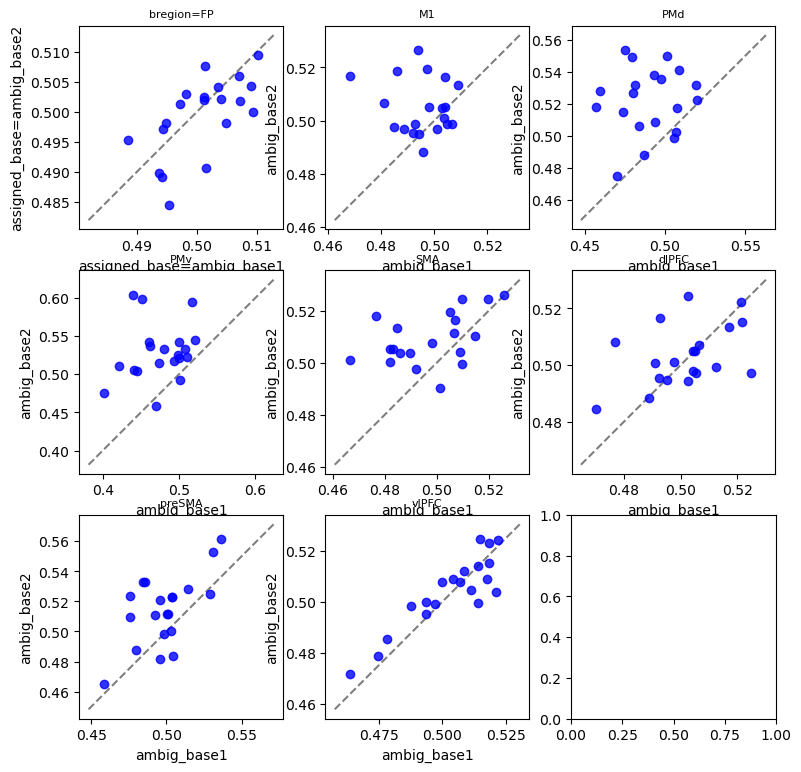

In [31]:
from pythonlib.tools.pandastools import plot_45scatter_means_flexible_grouping
plot_45scatter_means_flexible_grouping(DFPROJ_INDEX_AGG_SCAL_2, "assigned_base", "ambig_base1", "ambig_base2", "bregion", 
                                       "dist_index", "an_da_ms", False)